In [ ]:
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
import torch 
import torch.nn as nn
import torch.optim as optim

In [ ]:
from IPython.display import clear_output

In [ ]:
languages=[]
data=[]
x=[]
y=[]

with open('name2lang.txt','r') as f:
  for line in f:
    line=line.split(',')
    name=line[0].strip()
    lang=line[1].strip()
    if not lang in languages:
      languages.append(lang)
    x.append(name)
    y.append(lang)
    data.append((name,lang))

n_languages=len(languages)




In [ ]:
len(x)

20050

In [ ]:
print(languages)
print(n_languages)

['Portuguese', 'Irish', 'Spanish', 'Vietnamese', 'Chinese', 'Greek', 'Czech', 'Dutch', 'Japanese', 'French', 'German', 'Scottish', 'English', 'Russian', 'Polish', 'Arabic', 'Korean', 'Italian']
18


In [ ]:
print(data[0:10])

[('Abreu', 'Portuguese'), ('Albuquerque', 'Portuguese'), ('Almeida', 'Portuguese'), ('Alves', 'Portuguese'), ('Araujo', 'Portuguese'), ('Araullo', 'Portuguese'), ('Barros', 'Portuguese'), ('Basurto', 'Portuguese'), ('Belo', 'Portuguese'), ('Cabral', 'Portuguese')]


In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0,stratify=y)

In [ ]:
print(len(x_train),len(x_test))

16040 4010


#Encoding names and and languages

In [ ]:
all_letters=string.ascii_letters + " .,:'"
n_letter=len(all_letters)

In [ ]:
def name_rep(name):
  rep=torch.zeros(len(name),1,n_letter)
  for index,letter in enumerate(name):
    pos=all_letters.find(letter)
    rep[index][0][pos]=1
  return rep


In [ ]:
def lang_rep(lang):
  return torch.tensor([languages.index(lang)],dtype=torch.long)

In [ ]:
name_rep("Abreu") #Since 5 letter hence 52 dimension vector for each letter

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

In [ ]:
lang_rep("Portuguese")

tensor([0])

#Basic Visualization

In [ ]:
count={}
for l in languages:
  #print(l)
  count[l]=0
for d in data:
  count[d[1]] +=1  

In [ ]:
print(count)

{'Portuguese': 74, 'Irish': 232, 'Spanish': 298, 'Vietnamese': 73, 'Chinese': 268, 'Greek': 203, 'Czech': 519, 'Dutch': 297, 'Japanese': 991, 'French': 277, 'German': 724, 'Scottish': 100, 'English': 3668, 'Russian': 9384, 'Polish': 139, 'Arabic': 2000, 'Korean': 94, 'Italian': 709}


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


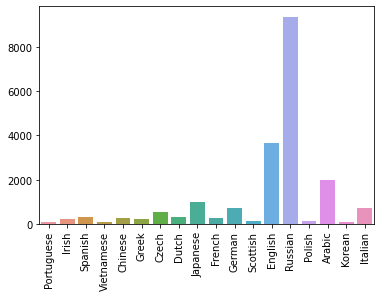

In [ ]:
plt_=sns.barplot(list (count.keys()),list (count.values()) )
plt_.set_xticklabels(plt_.get_xticklabels(),rotation=90)
plt.show()

**Input Size**-The size of representation of one character

**Output Size**-No. of languages we have

In [ ]:
class RNN_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_net, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size+hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size+hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input_, hidden = None):
        combined=torch.cat((input_, hidden),1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
n_hidden = 128
net = RNN_net(n_letter, n_hidden, n_languages)

In [ ]:
def infer(net,name):
    net.eval()
    name_ohe = name_rep(name)
    
    hidden = net.init_hidden()
    for i in range(name_ohe.size()[0]):
      output,hidden=net(name_ohe[i],hidden) # applying several forward paas as many as there are characters
      # Also we are overwriting the output ,hence we will get only last layer output
      #Which correspond to the Language which that particular word belong to
    
    return output

In [ ]:
output=infer(net,'Ádam')

index=torch.argmax(output)
print(output,index)

tensor([[-2.8764, -2.9168, -2.8910, -2.9429, -2.8627, -2.8119, -2.8788, -2.8354,
         -2.8812, -2.8479, -2.9273, -2.9586, -2.8445, -2.9271, -2.9838, -2.8349,
         -2.8991, -2.9254]], grad_fn=<LogSoftmaxBackward>) tensor(5)


In [ ]:
def dataloader(npoints, X_, y_):
    to_ret = []
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        to_ret.append((name, lang, name_rep(name), lang_rep(lang)))
    return to_ret

In [ ]:
dataloader(2, x_train, y_train)

[('Hajjar',
  'Arabic',
  tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
def eval(net, n_points, k, X_, y_):
    
    data_ = dataloader(n_points, X_, y_)
    correct = 0
    
    for name, language, name_ohe, lang_rep in data_:
        
        output = infer(net, name)
        val, indices = output.topk(k)
        
        if lang_rep in indices:
            correct += 1
            
    accuracy = correct/n_points
    return accuracy

In [ ]:
eval(net, 1000, 3, x_test, y_test)

0.078

#Training

In [ ]:
def train(net, opt, criterion, n_points):
    
    opt.zero_grad()
    total_loss = 0
    
    data_ = dataloader(n_points, x_train, y_train)
    
    for name, language, name_ohe, lang_rep in data_:

        hidden = net.init_hidden()

        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i], hidden)
            
        loss = criterion(output, lang_rep)
        loss.backward(retain_graph=True)
        
        total_loss += loss
        
    opt.step()       
            
    return total_loss/n_points

In [ ]:
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [ ]:
%%time 
train(net, opt, criterion, 200)

CPU times: user 180 ms, sys: 30.2 ms, total: 211 ms
Wall time: 249 ms


tensor(2.9233, grad_fn=<DivBackward0>)

In [ ]:
eval(net, 1000, 1, x_test, y_test)

0.468

In [ ]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5):
    
    criterion = nn.NLLLoss()
    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train(net, opt, criterion, batch_size))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Top-1:', eval(net, len(x_test), 1, x_test, y_test), 'Top-2:', eval(net, len(x_test), 2, x_test, y_test), 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
                      

Iteration 99 Top-1: 0.6625935162094763 Top-2: 0.7822942643391522 Loss 1.4814579486846924


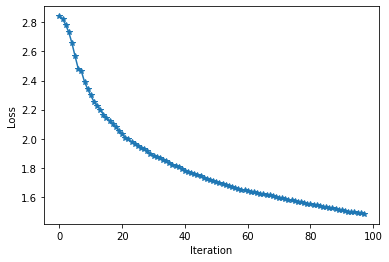

In [ ]:
n_hidden = 128
net = RNN_net(n_letter, n_hidden, n_languages)
train_setup(net, lr=0.0005, n_batches=100, batch_size = 256)

#LSTM

In [ ]:
class LSTM_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_net, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = nn.LSTM(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
    
    def forward(self, input_, hidden):
        out, hidden = self.lstm_cell(input_.view(1, 1, -1), hidden)
        output = self.h2o(hidden[0])
        output = self.softmax(output)
        return output.view(1, -1), hidden
    
    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))

In [ ]:
n_hidden = 128
net = LSTM_net(n_letters, n_hidden, n_languages)
train_setup(net, lr=0.0005, n_batches=100, batch_size = 256)

#GRU

In [ ]:
class GRU_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU_net, self).__init__()
        self.hidden_size = hidden_size
        self.gru_cell = nn.GRU(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
    
    def forward(self, input_, hidden):
        out, hidden = self.gru_cell(input_.view(1, 1, -1), hidden)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output.view(1, -1), hidden
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [ ]:
n_hidden = 128
net = LSTM_net(n_letters, n_hidden, n_languages)
train_setup(net, lr=0.0005, n_batches=100, batch_size = 256)

#Batching

In [ ]:
device_gpu=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def batched_name_rep(names, max_word_size):
    rep = torch.zeros(max_word_size, len(names), n_letter)  #2nd dimension represent batch size
    for name_index, name in enumerate(names):
        for letter_index, letter in enumerate(name):
            pos = all_letters.find(letter)
            rep[letter_index][name_index][pos] = 1
    return rep

In [ ]:
def print_char(name_reps):
    name_reps = name_reps.view((-1, name_reps.size()[-1]))
    for t in name_reps: 
        if torch.sum(t) == 0:
            print('<pad>')
        else:
            index = t.argmax()
            print(all_letters[index])

In [ ]:
out_ = batched_name_rep(['Shyam', 'Ram'], 5)
print(out_)
print(out_.shape)
print_char(out_)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0

In [ ]:
def batched_lang_rep(langs):
    rep = torch.zeros([len(langs)], dtype=torch.long)
    for index, lang in enumerate(langs):
        rep[index] = languages.index(lang)
    return rep
    

In [ ]:
def batched_dataloader(npoints, X_, y_, verbose=False, device = 'cpu'):
    names = []
    langs = []
    X_lengths = []
    
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        X_lengths.append(len(name))
        names.append(name)
        langs.append(lang)
    max_length = max(X_lengths)
    
    names_rep = batched_name_rep(names, max_length).to(device)
    langs_rep = batched_lang_rep(langs).to(device)
    #Packing
    padded_names_rep = torch.nn.utils.rnn.pack_padded_sequence(names_rep, X_lengths, enforce_sorted = False)
    
    if verbose:
        print(names_rep.shape, padded_names_rep.data.shape)
        print('--')
    
    if verbose:
        print(names)
        print_char(names_rep)
        print('--')
    
    if verbose:
        print_char(padded_names_rep.data)
        print('Lang Rep', langs_rep.data)
        print('Batch sizes', padded_names_rep.batch_sizes)
    
    
    return padded_names_rep.to(device), langs_rep

In [ ]:
p, l = batched_dataloader(3, x_train, y_train, True)

torch.Size([10, 3, 57]) torch.Size([28, 57])
--
['Bahlulzade', 'Yanagita', 'Mikhaltsev']
B
Y
M
a
a
i
h
n
k
l
a
h
u
g
a
l
i
l
z
t
t
a
a
s
d
<pad>
e
e
<pad>
v
--
B
M
Y
a
i
a
h
k
n
l
h
a
u
a
g
l
l
i
z
t
t
a
s
a
d
e
e
v
Lang Rep tensor([13,  8, 13])
Batch sizes tensor([3, 3, 3, 3, 3, 3, 3, 3, 2, 2])


In [ ]:
def train_batch(net, opt, criterion, n_points, device = 'cpu'):
    
    net.train().to(device)
    opt.zero_grad()
    
    batch_input, batch_groundtruth = batched_dataloader(n_points, x_train, y_train, False, device)
    
    output, hidden = net(batch_input)
    
    loss = criterion(output, batch_groundtruth)
    
    loss.backward()
    opt.step()
    return loss

In [ ]:
net = RNN_net(n_letter, n_hidden, n_languages)
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [ ]:
%%time 
train(net, opt, criterion, 256)

CPU times: user 225 ms, sys: 1.95 ms, total: 227 ms
Wall time: 233 ms


tensor(2.9195, grad_fn=<DivBackward0>)

#RNN_CELL

In [ ]:
class RNN_net_1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_net_1, self).__init__()
        self.hidden_size = hidden_size
        self.rnn_cell = nn.RNN(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input_, hidden = None, batch_size = 1):
        out, hidden = self.rnn_cell(input_, hidden)
        output = self.h2o(hidden.view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self, batch_size = 1):
        return torch.zeros(1, batch_size, self.hidden_size)

In [ ]:
def infer1(net, name, device = 'cpu'):
    name_ohe = name_rep(name).to(device)
    
    output, hidden = net(name_ohe)
        
    if type(hidden) is tuple: # For LSTM
        hidden = hidden[0]
    index = torch.argmax(hidden)
    
    return output

In [ ]:
def eval1(net, n_points, topk, X_, y_, device = 'cpu'):
    net = net.eval().to(device)
    data_ = dataloader(n_points, X_, y_)
    correct = 0
    
    for name, language, name_ohe, lang_rep in data_:
        
        output = infer1(net, name, device)
        val, indices = output.topk(topk)
        indices = indices.to('cpu')
        
        if lang_rep in indices:
            correct += 1
            
    accuracy = correct/n_points
    return accuracy

In [ ]:
net = RNN_net_1(n_letter, n_hidden, n_languages)
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [ ]:
%%time 
train_batch(net, opt, criterion, 256)

CPU times: user 28.5 ms, sys: 5.04 ms, total: 33.6 ms
Wall time: 75.2 ms


tensor(2.8688, grad_fn=<NllLossBackward>)

#Full Train

In [ ]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    net = net.to(device)
    criterion = nn.NLLLoss()
    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    print('Top-1:', eval1(net, len(x_test), 1, x_test, y_test, device), 'Top-2:', eval1(net, len(x_test), 2, x_test, y_test, device))
                      

Iteration 4999 Loss 0.43510302901268005


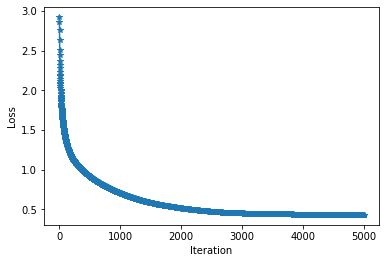

NameError: ignored

In [ ]:
%%time
net = RNN_net_1(n_letter, 128, n_languages)
train_setup(net, lr=0.15, n_batches=5000, batch_size = 512, display_freq=500) # CPU Training example

In [ ]:
%%time
net = RNN_net(n_letters, 128, n_languages)
train_setup(net, lr=0.15, n_batches=5000, batch_size = 512, display_freq=100, device = device_gpu) # GPU Training Example

#LSTM Cell

In [ ]:
device_gpu=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class LSTM_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_net, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = nn.LSTM(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden = None):
        out, hidden = self.lstm_cell(input, hidden)
        output = self.h2o(hidden[0].view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self, batch_size = 1):
        return (torch.zeros(1, batch_size, self.hidden_size), torch.zeros(1, batch_size, self.hidden_size))

Iteration 999 Loss 0.9622565507888794


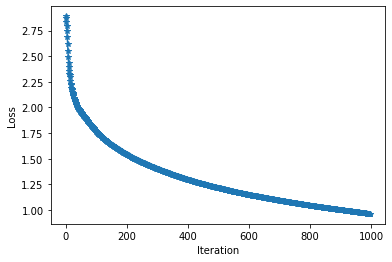




Top-1: 0.7910224438902743 Top-2: 0.8815461346633416


In [ ]:
n_hidden = 128
net = LSTM_net(n_letter, n_hidden, n_languages)
train_setup(net, lr=0.15, n_batches=1024, batch_size = 512, display_freq=1000, device = device_gpu)

#GRU Cell

In [ ]:
class GRU_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU_net, self).__init__()
        self.hidden_size = hidden_size
        self.gru_cell = nn.GRU(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden = None):
        out, hidden = self.gru_cell(input, hidden)
        output = self.h2o(hidden.view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden

In [ ]:
n_hidden = 128
net = GRU_net(n_letter, n_hidden, n_languages)
train_setup(net, lr=0.15, n_batches=8000, batch_size = 512, display_freq=1000, device = device_gpu)